# SOM from scratch
In this Notebook we are going to implement a Self Organizing Map model. A brief showcase of its capabilities will be then given subsequently.

### Defining The model
Before doing anything, we start by defining the model class.
Since we are using `numpy`, we can avoid using an explicit loop to update all the weights in favor of `numpy`'s array operations that are a lot more efficient and parallelizable. 

In [1]:
import numpy as np
import random

np.set_printoptions(precision=2)
np.random.seed(2021)

def h(x, bmu, sigma): 
  dist = np.linalg.norm(x - bmu, axis = len(x.shape)-1)
  return np.exp(-(dist**2) / (2 * sigma) **2)

class SOM:
    def __init__(self, nrow, ncol, input_units):
      self.weights = np.random.rand(nrow, ncol, input_units)
      self.grid = np.array([[(i, j) for j in range(0, ncol)] for i in range(0, nrow)])

    def train(self, train_data, iterations, eta, sigma, eta_decay, sigma_decay):
      sigma_0 = sigma
      eta_0 = eta
      # Define both sigma(n) and eta(n)
      sigma = lambda n: sigma_0 * np.exp(-n / sigma_decay)
      eta = lambda n: eta_0 * np.exp(-n / eta_decay)

      for n in range(0, iterations):
        x_i = train_data[np.random.randint(0, len(train_data)-1)]

        dist = np.linalg.norm(self.weights - x_i, axis = len(self.weights.shape)-1)

        # First thing first, we need to compute the BMU.
        # Get the index with the minimum value inside the distance matrix
        bmu_index = np.argmin(dist)
        # then convert it into a 2-D index (numpy returns only 1-D indexes)
        bmu_index = np.unravel_index(bmu_index, dist.shape)
        bmu = self.weights[bmu_index]

        # We then h values for each neuron. (The corresponding Gaussian will be centered at BMU)
        h_vals = h(self.grid, bmu_index, sigma(n))

        # We can then apply in parallel the weights update
        self.weights += (eta(n) * h_vals[..., None] * (x_i - self.weights))

    def plot_data(self):
      if(self.weights.shape[2] == 2):
        nrow, ncol = self.weights.shape[0], self.weights.shape[1]
        points = self.weights.reshape(nrow * ncol, 2)
        return points[:, 0], points[:, 1]
      else:
        raise Exception('Cannot plot higher dimensional data (>2)')


### Testing the Map
In order to test the map, we are going to create a sample of 100 points from a uniform distribution and try to fit the SOM with such points.
A SOM can be represented in 2 different spaces:
* Output space: by plotting the *position* of the neurons inside the *lattice*
* Input space: by plotting the *prototype vectors* (weight vector) of the neurons in the input space

Off course, if we have more than 2 dimensions as input space, we won't be able to print the corresponding neurons. Here we are goint to plot the SOM in a 2-D space just to showcase its self-organizing process.

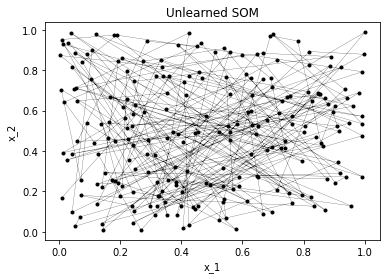

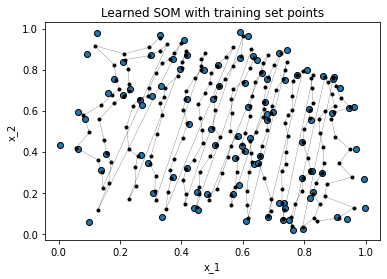

In [2]:

import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

# Create the dataset
X = np.random.rand(100,2)

# Create a 15x15 SOM, with 2-dimensional prototype vectors
som = SOM(15, 15, 2)
neurons_x, neurons_y = som.plot_data()
# Here is the SOM initialized, plotted in the input space
plt.plot(neurons_x, neurons_y, linewidth=0.2, marker='.', color='k')

plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title(label='Unlearned SOM')
plt.show()

n_iter = 5000

# proportional to the number of iteerations
eta_decay = n_iter
sigma = 8                   
sigma_decay = 1000/np.log10(sigma)

som.train(X, n_iter, eta=0.1, sigma=sigma, eta_decay=eta_decay, sigma_decay=sigma_decay)
neurons_x, neurons_y = som.plot_data()
plt.scatter(X[:, 0], X[:, 1], edgecolor="k")
plt.plot(neurons_x, neurons_y, linewidth=0.2, marker='.', color='k')
plt.title(label='Learned SOM with training set points')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

As you can see, the map organizes itself by pushing the weight vectors towards the best representations that activate the corresponding neurons.